In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training data size: {len(trainset)}")
print(f"Test data size: {len(testset)}")


Training data size: 50000
Test data size: 10000


In [6]:
# prompt: Adapt the two cells above with the ddpm to my dataset loaded earlier so that i am able to train it
import torch
import torchvision
import torchvision.transforms as transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import os

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training data size: {len(trainset)}")
print(f"Test data size: {len(testset)}")


model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,  # CIFAR-10 images are 32x32
    timesteps = 1000
)


dataset_dir = './cifar10_images'
os.makedirs(dataset_dir, exist_ok=True)

image_count = 0
for i, (images, labels) in enumerate(trainloader):
    for j, image in enumerate(images):
        torchvision.utils.save_image(image, os.path.join(dataset_dir, f'image_{i}_{j}.png'))
        image_count += 1
        if image_count >= 100:
            break
    if image_count >= 100:
        break

Training data size: 50000
Test data size: 10000


In [7]:
trainer = Trainer(
    diffusion,
    dataset_dir,  # Use the path to the directory containing CIFAR-10 images
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 100000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)

trainer.train()
trainer.save('ddpm_cifar')

c:\Users\realc\OneDrive\Documents\noise-efficient-diffusion-model\venv\Lib\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to C:\Users\realc/.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth
100.0%
loss: 0.1431:   0%|          | 124/100000 [28:45<386:07:09, 13.92s/it]


KeyboardInterrupt: 

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

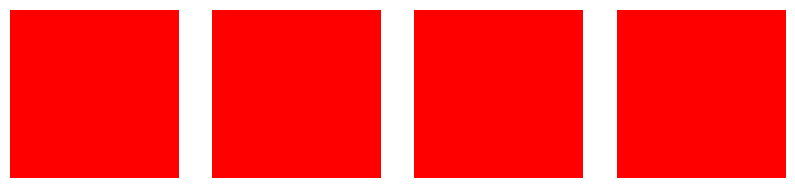

In [11]:
# prompt: based on the trained model, plot as many metrics as you can about it and generate some results

import matplotlib.pyplot as plt

# Assuming trainer has a history attribute containing metrics during training
if hasattr(trainer, 'history'):
  # Plot loss
  plt.figure(figsize=(10, 5))
  plt.plot(trainer.history['loss'])
  plt.xlabel('Training Steps')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.show()

  # If FID is calculated, plot it
  if 'fid' in trainer.history:
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.history['fid'])
    plt.xlabel('Training Steps')
    plt.ylabel('FID')
    plt.title('FID Score During Training')
    plt.show()

sampled_images = diffusion.sample(batch_size=4)


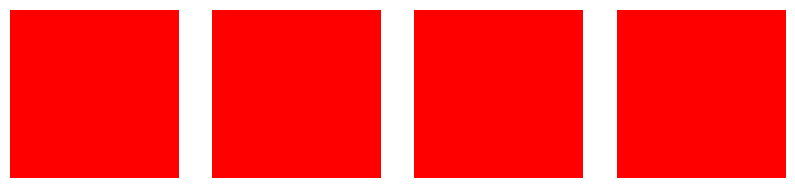

In [15]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(sampled_images[i].permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
plt.show()